In [ ]:
#all libary package used in this script:
import requests  # Import requests library to fetch data from the NYT API
import pandas as pd  # Import pandas for data manipulation and analysis
from collections import Counter  # Import Counter to count occurrences of keywords
import matplotlib.pyplot as plt  # Import matplotlib for creating plots
import seaborn as sns  # Import seaborn for advanced plotting features

In [ ]:
with open('api_key.py') as f:
    exec(f.read())

# Verify the API key
print('API Key is verified')

API Key is verified


In [ ]:
# 1. Data Collection:
def fetch_filtered_articles(section, start_date, end_date, api_key):
    # Construct URL for the API request with filters
    url = (
        f"https://api.nytimes.com/svc/search/v2/articlesearch.json?"
        f"fq=news_desk:({section})&begin_date={start_date}&end_date={end_date}&api-key={api_key}"
    )
    response = requests.get(url) # Send GET request to the API
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
         # Extract and return the list of articles from the JSON response
        articles = response.json()['response']['docs']
        return articles
    else:
        # Print an error message if request failed
        print(f"Failed to fetch articles: {response.status_code}")
        return None

"""Extracts headlines, publication dates, and keywords from articles and
 returns them as a DataFrame"""
def extract_data(articles):
   # Extract headlines, publication dates, and keywords from each article
    headlines = [article['headline']['main'] for article in articles]
    publication_dates = [article['pub_date'] for article in articles]
    keywords = [', '.join(keyword['value'] for keyword in article.get('keywords', [])) for article in articles]
    # Create and return a DataFrame with the extracted data
    return pd.DataFrame({'Headline': headlines, 'Publication Date': publication_dates, 'Keywords': keywords})

# Get user input for news section, start date, and end date
section = input("Enter the news section (e.g., Technology, Politics): ").capitalize()
start_date = input("Enter the start date (YYYYMMDD): ")
end_date = input("Enter the end date (YYYYMMDD): ")

# Fetch articles based on user input
articles = fetch_filtered_articles(section, start_date, end_date, api_key)

# If articles are successfully fetched, process and display them
if articles:
    df = extract_data(articles)  # Extract data from articles

    # Print first 10 headlines
    print("\nHeadlines:")
    for i, headline in enumerate(df['Headline'][:10], 1):
        print(f"{i}. {headline}")

    # Print first 10 publication dates
    print("\nPublication Dates:")
    for pub_date in df['Publication Date'][:10]:
        print(pub_date)

    # Print first 10 keywords
    print("\nKeywords:")
    for keywords in df['Keywords'][:10]:
        print(keywords)
else:
    print("No articles were fetched.")

Enter the news section (e.g., Technology, Politics): Politics
Enter the start date (YYYYMMDD): 20240601
Enter the end date (YYYYMMDD): 20240725

Headlines:
1. Trump’s Team Plans to Go After Kamala Harris at Republican Convention
2. Trump and His Allies Adapt to a New Role: Fighting for Attention
3. Kennedy Vows to Cut Military Budget in Half
4. Amid the Mayhem, Trump Pumped His Fist and Revealed His Instincts
5. Super PAC Tied to Elon Musk Is Being Guided by Ex-DeSantis Aides
6. Biden Addresses Gun-Control Group Hours After Son’s Firearms Conviction
7. Kimberly Guilfoyle’s Convention Sequel
8. Peter Navarro, Trump Trade Adviser, Heads From Prison to Convention
9. Democratic Delegates See Harris as the Strongest Candidate Against Trump
10. For Trump, Doug Burgum Emerges as a Safe Option, and a Wild Card

Publication Dates:
2024-07-11T21:13:41+0000
2024-07-25T09:03:38+0000
2024-06-14T01:31:57+0000
2024-07-14T03:24:29+0000
2024-07-23T23:32:37+0000
2024-06-11T19:44:37+0000
2024-07-18T00:59

In [ ]:
# 2. Basic Data Analysis part 1
# Analyzes and counts keyword occurrences in the articles
def analyze_keywords(df):
    # Combine all keywords into a single list
    all_keywords = ', '.join(df['Keywords']).split(', ')
    keyword_counts = Counter(all_keywords) # Count occurrences of each keyword
    return keyword_counts  # Return keyword counts

# Analyze keyword occurrences and print counts
keyword_counts = analyze_keywords(df)
print("\nKeyword Counts:")
for keyword, count in keyword_counts.most_common(10):
  print(f"{keyword}: {count}")


Keyword Counts:
Presidential Election of 2024: 10
Trump: 8
Donald J: 8
United States Politics and Government: 7
Biden: 4
Harris: 3
Kamala D: 3
Joseph R Jr: 3
Vice Presidents and Vice Presidency (US): 2
Democratic Party: 2



Keyword Trends:
Presidential Election of 2024: increasing
Trump: increasing
Donald J: increasing
United States Politics and Government: increasing
Biden: steady
Joseph R Jr: increasing
Harris: increasing
Kamala D: increasing
Vice Presidents and Vice Presidency (US): decreasing
Democratic Party: increasing


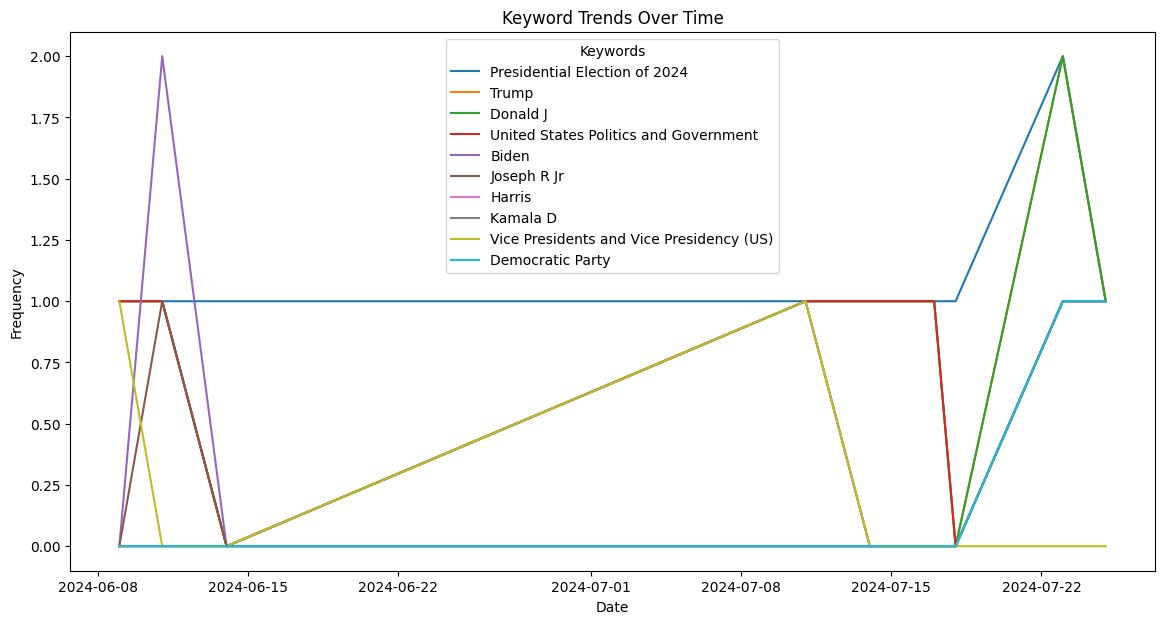

In [ ]:
# 2. Basic Data Analysis part 2
# Analyzes the frequency of keywords per day
def analyze_word_frequency(df):
    # Ensure 'Publication Date' is in datetime format
    df['Publication Date'] = pd.to_datetime(df['Publication Date'])
    # Group by publication date and aggregate keywords
    daily_keywords = df.groupby(df['Publication Date'].dt.date)['Keywords'].apply(lambda x: ', '.join(x).split(', '))
    # Count keywords per day
    daily_keyword_counts = daily_keywords.apply(lambda keywords: Counter(keywords))
    return daily_keyword_counts # Return daily keyword counts


# Analyzes trends in keyword frequency (increasing, decreasing, steady)
def analyze_trends(daily_keyword_counts):
    # Combine daily keyword counts into a DataFrame
    combined_counts = pd.DataFrame(daily_keyword_counts.tolist(), index=daily_keyword_counts.index).fillna(0)
    # Get top 10 keywords
    top_keywords = combined_counts.sum().nlargest(10).index
    trends = {}
    # Analyze trends for top keywords
    for keyword in top_keywords:
        # Calculate the frequency in the first and second half
        first_half = combined_counts[keyword][:len(combined_counts)//2].sum()
        second_half = combined_counts[keyword][len(combined_counts)//2:].sum()
        if second_half > first_half:
            trends[keyword] = 'increasing'
        elif second_half < first_half:
            trends[keyword] = 'decreasing'
        else:
            trends[keyword] = 'steady'
    return trends  # Return trends

# Plots trends of top keywords over time
def plot_keyword_trends(daily_keyword_counts):
    # Combine daily keyword counts into a DataFrame
    combined_counts = pd.DataFrame(daily_keyword_counts.tolist(), index=daily_keyword_counts.index).fillna(0)
    top_keywords = combined_counts.sum().nlargest(10).index # Get top 10 keywords
    combined_counts[top_keywords].plot(figsize=(14, 7)) # Plot keyword trend
    # Configure the plot's title, axis labels, and legend
    plt.title('Keyword Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend(title='Keywords')
    plt.show() # Display the plot


# Analyze word frequency over time
daily_keyword_counts = analyze_word_frequency(df)
# Analyze and print trends for keywords
trends = analyze_trends(daily_keyword_counts)
print("\nKeyword Trends:")
for keyword, trend in trends.items():
  print(f"{keyword}: {trend}")
# Plot keyword trends over time
plot_keyword_trends(daily_keyword_counts)

<ipython-input-8-c0d93f47cb07>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette='viridis', orient='h')


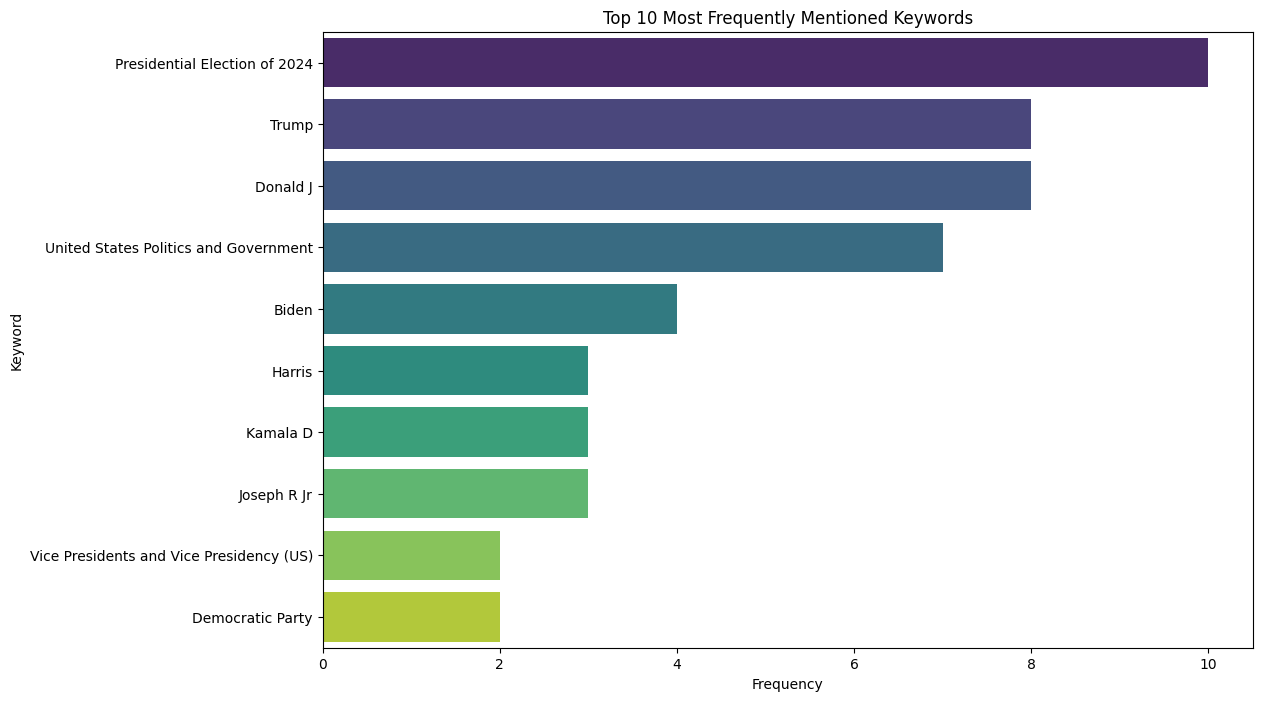

In [ ]:
# 3. Data Visualization Part 1
# Plots a bar chart of the top 10 most frequently mentioned keywords
def plot_top_keywords(keyword_counts):
    # Get top 10 most frequent keywords
    top_keywords = dict(keyword_counts.most_common(10))
    plt.figure(figsize=(12, 8))  # Create a figure with specified size
    # Plot bar chart for top keywords
    sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette='viridis', orient='h')
    # Configure the plot's title and axis labels
    plt.title('Top 10 Most Frequently Mentioned Keywords')
    plt.xlabel('Frequency')
    plt.ylabel('Keyword')
    plt.show()  # Display the plot

# Plot the top 10 most frequently mentioned keywords
plot_top_keywords(keyword_counts)

<ipython-input-9-6e89f4f47ad0>:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  weekly_articles = df.groupby(df['Publication Date'].dt.to_period('W')).size()


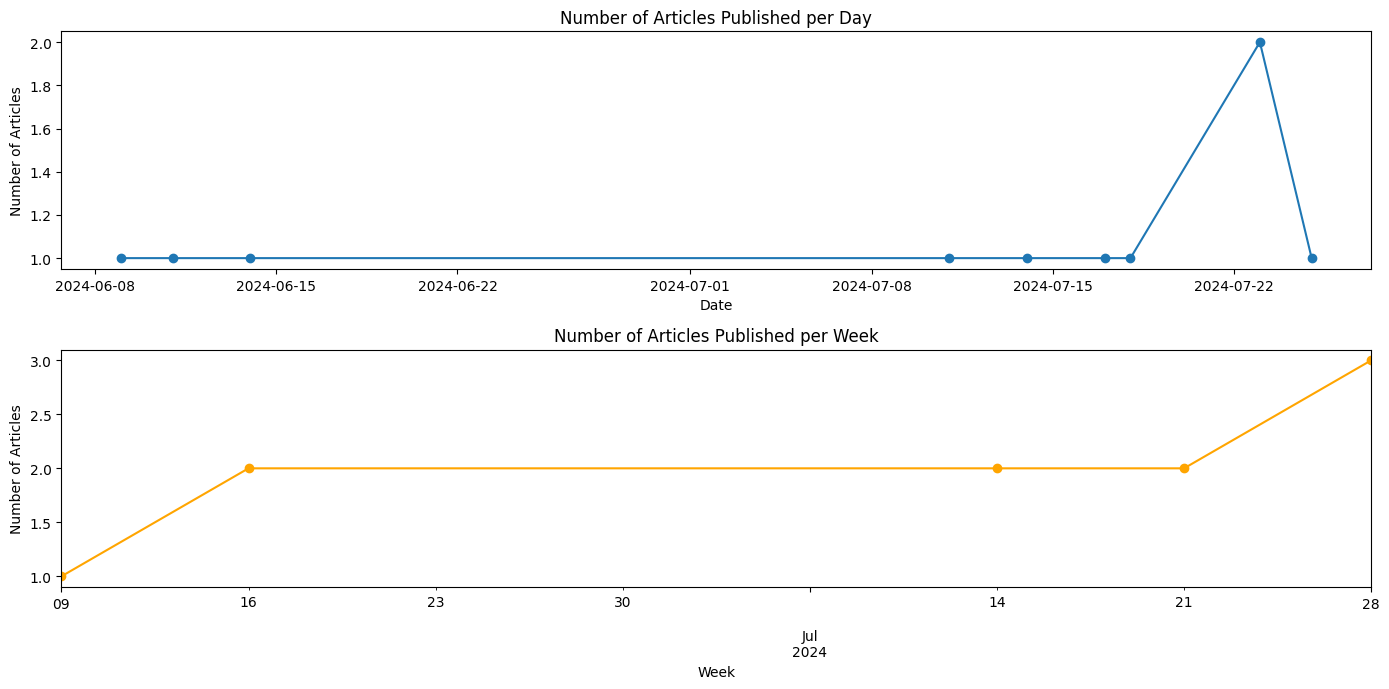

In [ ]:
# 3. Data Visualization Part 2
# Plots line graphs showing the number of articles published per day and per week
def plot_article_trends(df):
    # Get number of articles per day
    daily_articles = df.groupby(df['Publication Date'].dt.date).size()
    #Get number of articles per week
    weekly_articles = df.groupby(df['Publication Date'].dt.to_period('W')).size()

    plt.figure(figsize=(14, 7))  # Create a figure with specified size
    # Plot number of articles per day
    plt.subplot(2, 1, 1)
    daily_articles.plot(kind='line', marker='o')
    # Configure the plot's title and axis labels
    plt.title('Number of Articles Published per Day')
    plt.xlabel('Date')
    plt.ylabel('Number of Articles')

    # Plot number of articles per week
    plt.subplot(2, 1, 2)
    weekly_articles.plot(kind='line', marker='o', color='orange')
    # Configure the plot's title and axis labels
    plt.title('Number of Articles Published per Week')
    plt.xlabel('Week')
    plt.ylabel('Number of Articles')

    plt.tight_layout()  # Adjust layout to fit plots
    plt.show()  # Display the plots

# Plot article publication trends per day and week
plot_article_trends(df)